# kamAI

We will demonstrate a system that recognizes numbers from hand gestures.  
It is similar to the final project in Coursera's `Improving Deep Neural Networks: Hyperparameter tuning, Regularization and Optimization` but will be implemented using `Tensorflow 2`.  
<img src="images/hand-gestures.png">  
  
Let's start with the modules needed.

In [1]:
import tensorflow as tf
import numpy as np
import h5py
import matplotlib.pyplot as plt

## Explore the dataset

We load the dataset from the H5 files.

In [2]:
train_dataset = h5py.File('datasets/train_signs.h5', "r")

train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

test_dataset = h5py.File('datasets/test_signs.h5', "r")
test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

classes = np.array(test_dataset["list_classes"][:]) # the list of classes

train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0])).T
test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0])).T

print ("train_set_x_orig's shape: " + str(train_set_x_orig.shape))
print ("train_set_y_orig's shape: " + str(train_set_y_orig.shape))
print ("test_set_x_orig's shape: " + str(test_set_x_orig.shape))
print ("test_set_y_orig's shape: " + str(test_set_y_orig.shape))

# normalize values between 0 to 1
train_set_x_orig = train_set_x_orig / 255
test_set_x_orig = test_set_x_orig / 255

train_set_x_orig's shape: (1080, 64, 64, 3)
train_set_y_orig's shape: (1080, 1)
test_set_x_orig's shape: (120, 64, 64, 3)
test_set_y_orig's shape: (120, 1)


In the training samples, we have 1080 `64 x 64 x 3` RGB images while the test samples have 120 RGB images.  
  
Here are the images from the training set.

In [3]:
for index in range(len(train_set_x_orig)):
    plt.imshow(train_set_x_orig[index])
    print("idx(" + str(index) +") y("+str(train_set_y_orig.T[0,index])+") : " + str(classes[train_set_y_orig.T[0,index]]))
    plt.show()

Here are the images from the test set.

In [4]:
for index in range(len(test_set_x_orig)):
    plt.imshow(test_set_x_orig[index])
    print("idx(" + str(index) +") y("+str(test_set_y_orig.T[0,index])+") : " + str(classes[test_set_y_orig.T[0,index]]))
    plt.show()

## Model Creation

Let's try to create a 3-layer neural network model for this problem.  
Note that the problem now has `multiple classes for classification` which can be extended from the `binary classification` problem.  
  
This command is called first to avoid casting of float64 to float32 (Tensorflow warning).

In [3]:
tf.keras.backend.set_floatx('float64')
model_dir = 'models/initial_model'  # used for saving and loading a trained model

Similar to what we did in the cat classification problem in [cAIt-sith](https://github.com/scrappycoc0/cAIth-sith), we will make a stack of layers using Tensorflow.  
What differs from [cAIt-sith](https://github.com/scrappycoc0/cAIth-sith) is that, the last node will require `softmax` activation function since we have a multiple classification problem.  
  
<font color='red'>Note that we did not put the `softmax` activation on purpose as we plan to use the logits output instead.</font>  
See the more helpful explanation from [Tensorflow](https://www.tensorflow.org/tutorials/quickstart/beginner) instead.

In [5]:
num_of_possible_output = 6 # 0 - 5 values using 1-hand gesture

# hyperparameters
model_struct = [(25, 'relu'), (12, 'relu')]
learning_rate = 0.0001
dropout_rate = 0.01

# create model
model = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=train_set_x_orig[0].shape),
            tf.keras.layers.Dropout(dropout_rate)
        ])

# add hidden layers
for layer_param in model_struct:
    model.add(tf.keras.layers.Dense(layer_param[0], activation=layer_param[1]))
    model.add(tf.keras.layers.Dropout(dropout_rate))

# final layer for softmax regression
model.add(tf.keras.layers.Dense(num_of_possible_output))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 12288)             0         
_________________________________________________________________
dropout (Dropout)            (None, 12288)             0         
_________________________________________________________________
dense (Dense)                (None, 25)                307225    
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                312       
_________________________________________________________________
dropout_2 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 7

The dataset label is represented by a single value between 0 to 5 that represents the hand gestures.  
To use Tensorflow, we must do a `one hot encoding` to it.  
<img src="images/onehot.png" width="500" height="250"> 

In [21]:
# one-hot encoding for training labels
oh = tf.one_hot(train_set_y_orig, num_of_possible_output) # one hot tensor
one_hot_training_labels = oh.numpy()
print('One hot training shape: ' + str(one_hot_training_labels.shape))

# removes the unnecessary 3rd dimension after tf.one_hot()
# turns the (m x 1 x num_of_possible_output) matrix to an (m x num_of_possible_output) vector
one_hot_training_labels = one_hot_training_labels.reshape(one_hot_training_labels.shape[0], -1)
print('One hot training shape (after reshape): ' + str(one_hot_training_labels.shape))

One hot training shape: (1080, 1, 6)
One hot training shape (after reshape): (1080, 6)


Since this is a multiple classification problem, we cannot use the `Binary Cross Entropy` as a loss function.  
Instead, we can use [Categorical Cross Entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy?hl=en) or [Sparse Categorical Cross Entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy?hl=en).  
On the documentation itself, it says that the `Categorical Cross Entropy` expects that the labels are in `one hot encoding`.  
Since we already performed the `one hot encoding` in our labels, we might as well use the `Categorical Cross Entropy`.  
  
Note here that the `tf.nn.softmax()` converts the logits to probabilities in the prediction, so we can:
1. Use the probabilities and the loss function where the parameter `from_logits=False`, or
2. Use the logits and the loss function where the parameter `from_logits=True`

In [22]:
# loss
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# prediction
predictions = model(train_set_x_orig).numpy()

print('Initial loss is ' + str(loss_function(one_hot_training_labels, predictions).numpy()))

Initial loss is 1.897217869758606


Finally, we define the optimizer and metric to have the compilation.

In [23]:
# optimizer
optim_adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# compilation
model.compile(optimizer=optim_adam, loss=loss_function, metrics=['accuracy'])

Let's start training!

In [24]:
history = model.fit(train_set_x_orig, one_hot_training_labels, epochs=500)

Epoch 1/500
34/34 [==============================] - 1s 26ms/step - loss: 1.8070 - accuracy: 0.1833 0s - loss:
Epoch 2/500
34/34 [==============================] - 1s 25ms/step - loss: 1.7944 - accuracy: 0.1796
Epoch 3/500
34/34 [==============================] - 1s 36ms/step - loss: 1.7781 - accuracy: 0.2083
Epoch 4/500
34/34 [==============================] - 1s 29ms/step - loss: 1.7446 - accuracy: 0.2463 0s - loss: 1.7540 - accura
Epoch 5/500
34/34 [==============================] - 1s 26ms/step - loss: 1.7297 - accuracy: 0.2417
Epoch 6/500
34/34 [==============================] - 1s 25ms/step - loss: 1.7091 - accuracy: 0.2806
Epoch 7/500
34/34 [==============================] - 1s 33ms/step - loss: 1.6924 - accuracy: 0.2704
Epoch 8/500
34/34 [==============================] - 1s 27ms/step - loss: 1.6616 - accuracy: 0.3241 0s - loss: 1.6666 - accura
Epoch 9/500
34/34 [==============================] - 1s 25ms/step - loss: 1.6672 - accuracy: 0.3000
Epoch 10/500
34/34 [===============

34/34 [==============================] - 1s 29ms/step - loss: 0.7663 - accuracy: 0.7407
Epoch 160/500
34/34 [==============================] - 1s 28ms/step - loss: 0.7403 - accuracy: 0.7454
Epoch 161/500
34/34 [==============================] - 1s 28ms/step - loss: 0.7811 - accuracy: 0.7324
Epoch 162/500
34/34 [==============================] - 1s 29ms/step - loss: 0.7547 - accuracy: 0.7333
Epoch 163/500
34/34 [==============================] - 1s 27ms/step - loss: 0.7533 - accuracy: 0.7343
Epoch 164/500
34/34 [==============================] - 1s 30ms/step - loss: 0.7464 - accuracy: 0.7389 0s - loss: 0.7366 - accuracy: 0.
Epoch 165/500
34/34 [==============================] - 1s 27ms/step - loss: 0.7580 - accuracy: 0.7250
Epoch 166/500
34/34 [==============================] - 1s 30ms/step - loss: 0.7560 - accuracy: 0.7296
Epoch 167/500
34/34 [==============================] - 1s 26ms/step - loss: 0.7717 - accuracy: 0.7407
Epoch 168/500
34/34 [==============================] - 1s 27ms/

34/34 [==============================] - 1s 29ms/step - loss: 0.4846 - accuracy: 0.8528
Epoch 316/500
34/34 [==============================] - 1s 24ms/step - loss: 0.5044 - accuracy: 0.8565
Epoch 317/500
34/34 [==============================] - 1s 27ms/step - loss: 0.4905 - accuracy: 0.8565
Epoch 318/500
34/34 [==============================] - 1s 38ms/step - loss: 0.5039 - accuracy: 0.8537
Epoch 319/500
34/34 [==============================] - 1s 35ms/step - loss: 0.4933 - accuracy: 0.8509
Epoch 320/500
34/34 [==============================] - 1s 37ms/step - loss: 0.5012 - accuracy: 0.8500 0s - loss: 0.5159 - ac
Epoch 321/500
34/34 [==============================] - 1s 35ms/step - loss: 0.5027 - accuracy: 0.8519
Epoch 322/500
34/34 [==============================] - 1s 35ms/step - loss: 0.4824 - accuracy: 0.8639
Epoch 323/500
34/34 [==============================] - 1s 34ms/step - loss: 0.5045 - accuracy: 0.8444
Epoch 324/500
34/34 [==============================] - 1s 27ms/step - los

34/34 [==============================] - 1s 27ms/step - loss: 0.3435 - accuracy: 0.9000
Epoch 472/500
34/34 [==============================] - 1s 27ms/step - loss: 0.3672 - accuracy: 0.8972
Epoch 473/500
34/34 [==============================] - 1s 29ms/step - loss: 0.3104 - accuracy: 0.9093
Epoch 474/500
34/34 [==============================] - 1s 26ms/step - loss: 0.3472 - accuracy: 0.8972
Epoch 475/500
34/34 [==============================] - 1s 27ms/step - loss: 0.3298 - accuracy: 0.9065
Epoch 476/500
34/34 [==============================] - 1s 24ms/step - loss: 0.3443 - accuracy: 0.9009
Epoch 477/500
34/34 [==============================] - 1s 25ms/step - loss: 0.3163 - accuracy: 0.9167
Epoch 478/500
34/34 [==============================] - 1s 25ms/step - loss: 0.3266 - accuracy: 0.9074
Epoch 479/500
34/34 [==============================] - 1s 25ms/step - loss: 0.3570 - accuracy: 0.8972
Epoch 480/500
34/34 [==============================] - 1s 27ms/step - loss: 0.3725 - accuracy: 0

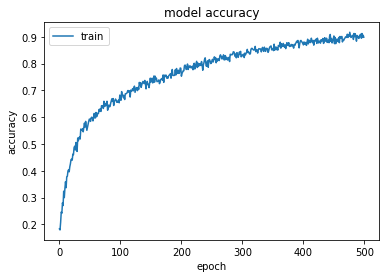

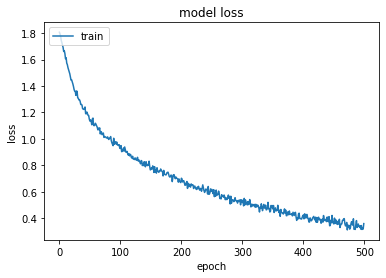

In [25]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

Let's save the model which can be loaded next time to avoid re-training again.

In [26]:
tf.keras.models.save_model(model, model_dir)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/initial_model\assets


## Model Evaluation

The current model we have has a training set accuracy of <b>89.81%</b>.  
Before we check the test set accuracy, we convert the test set labels to `one hot encoding` as well.

In [6]:
# one-hot encoding for test labels
oh = tf.one_hot(test_set_y_orig, num_of_possible_output) # one hot tensor
one_hot_test_labels = oh.numpy()
print('One hot test shape: ' + str(one_hot_test_labels.shape))

# removes the unnecessary 3rd dimension after tf.one_hot()
# turns the (m x 1 x num_of_possible_output) matrix to an (m x num_of_possible_output) vector
one_hot_test_labels = one_hot_test_labels.reshape(one_hot_test_labels.shape[0], -1)
print('One hot test shape (after reshape): ' + str(one_hot_test_labels.shape))

One hot test shape: (120, 1, 6)
One hot test shape (after reshape): (120, 6)


Now, we can evaluate the model's test set performance.

In [7]:
model.evaluate(test_set_x_orig, one_hot_test_labels, verbose=1)

4/4 [==============================] - 0s 6ms/step - loss: 0.5945 - accuracy: 0.7667


[0.5945025682449341, 0.7666666666666667]

This <b>76.67%</b> test set accuracy is a fair performance for such a simple model.

## Error Analysis

We can check some of the model's error which we could have some generalization to further improve its test set performance.  
Note that this could be a little different from the binary classification problem.  
  
The predictions can be converted from `logits` to probabilities via `tf.nn.softmax()`.  
Then we convert the probability vectors to `one hot encoding` by finding which of the classifications has the largest probability.  
  
If the one hot encoded prediction is not equal to its label, then we found a mislabeled data.  
<font color='red'>The `for-if` section can be further be improved if implemented in vectorized form.</font>

test_set_prediction shape:(120, 6)
max_prediction shape:(120,)
idx:0 oh label:[1. 0. 0. 0. 0. 0.] oh prediction:[0. 0. 0. 0. 0. 1.]


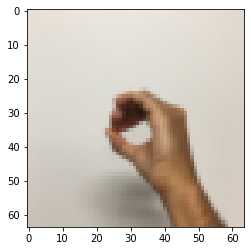

idx:8 oh label:[0. 0. 0. 0. 0. 1.] oh prediction:[0. 0. 0. 0. 1. 0.]


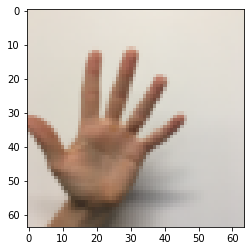

idx:23 oh label:[0. 0. 0. 0. 0. 1.] oh prediction:[0. 0. 0. 1. 0. 0.]


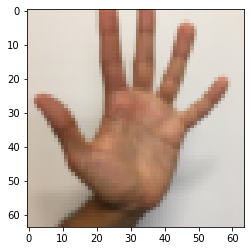

idx:24 oh label:[0. 0. 0. 1. 0. 0.] oh prediction:[1. 0. 0. 0. 0. 0.]


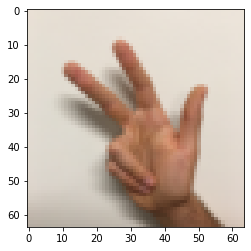

idx:27 oh label:[0. 0. 1. 0. 0. 0.] oh prediction:[0. 0. 0. 0. 1. 0.]


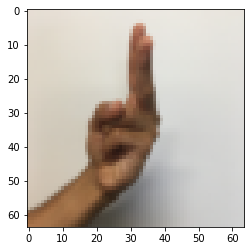

idx:29 oh label:[0. 0. 1. 0. 0. 0.] oh prediction:[0. 0. 0. 0. 0. 1.]


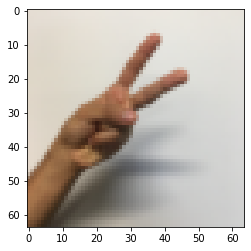

idx:30 oh label:[0. 0. 0. 1. 0. 0.] oh prediction:[0. 0. 0. 0. 1. 0.]


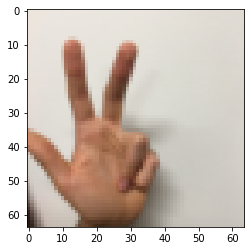

idx:36 oh label:[1. 0. 0. 0. 0. 0.] oh prediction:[0. 0. 0. 0. 0. 1.]


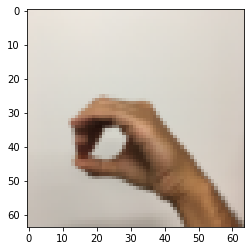

idx:37 oh label:[0. 0. 0. 0. 1. 0.] oh prediction:[0. 0. 0. 1. 0. 0.]


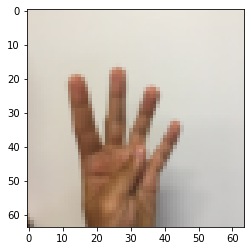

idx:47 oh label:[0. 0. 1. 0. 0. 0.] oh prediction:[0. 1. 0. 0. 0. 0.]


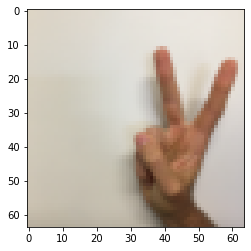

idx:54 oh label:[0. 0. 0. 0. 1. 0.] oh prediction:[0. 0. 1. 0. 0. 0.]


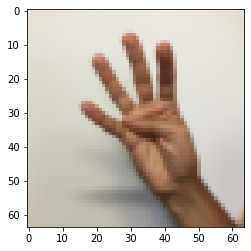

idx:59 oh label:[0. 0. 0. 0. 1. 0.] oh prediction:[0. 0. 0. 0. 0. 1.]


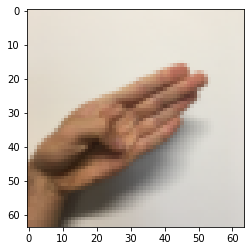

idx:61 oh label:[0. 0. 0. 0. 0. 1.] oh prediction:[0. 0. 0. 0. 1. 0.]


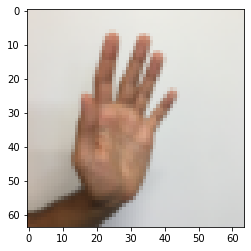

idx:64 oh label:[0. 0. 0. 0. 1. 0.] oh prediction:[1. 0. 0. 0. 0. 0.]


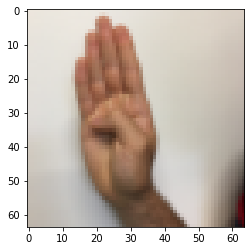

idx:65 oh label:[0. 0. 0. 0. 0. 1.] oh prediction:[0. 0. 0. 1. 0. 0.]


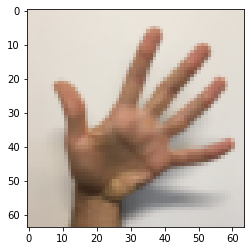

idx:68 oh label:[0. 0. 0. 1. 0. 0.] oh prediction:[1. 0. 0. 0. 0. 0.]


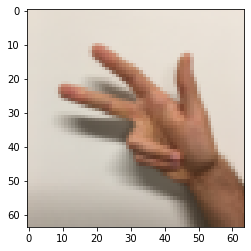

idx:71 oh label:[0. 0. 0. 0. 1. 0.] oh prediction:[0. 0. 0. 0. 0. 1.]


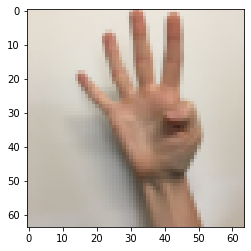

idx:72 oh label:[0. 1. 0. 0. 0. 0.] oh prediction:[0. 0. 0. 0. 0. 1.]


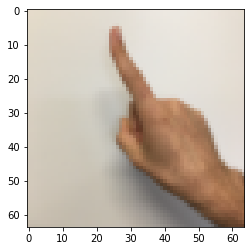

idx:75 oh label:[0. 0. 0. 0. 1. 0.] oh prediction:[0. 0. 0. 0. 0. 1.]


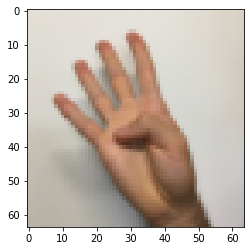

idx:79 oh label:[0. 0. 0. 0. 0. 1.] oh prediction:[1. 0. 0. 0. 0. 0.]


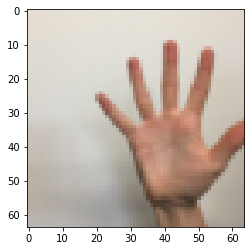

idx:83 oh label:[0. 0. 0. 0. 1. 0.] oh prediction:[0. 0. 0. 1. 0. 0.]


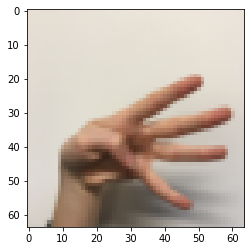

idx:85 oh label:[0. 0. 0. 0. 1. 0.] oh prediction:[0. 0. 0. 1. 0. 0.]


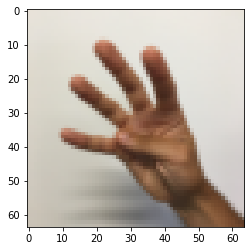

idx:93 oh label:[0. 0. 0. 0. 0. 1.] oh prediction:[0. 0. 1. 0. 0. 0.]


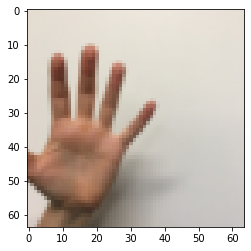

idx:103 oh label:[0. 0. 1. 0. 0. 0.] oh prediction:[0. 0. 0. 0. 1. 0.]


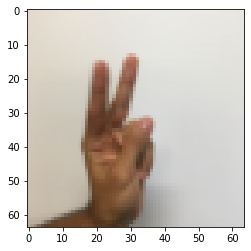

idx:109 oh label:[0. 0. 0. 0. 1. 0.] oh prediction:[0. 0. 0. 1. 0. 0.]


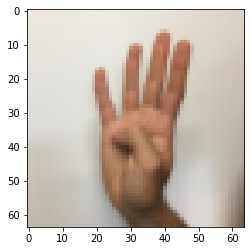

idx:111 oh label:[0. 0. 0. 1. 0. 0.] oh prediction:[0. 0. 0. 0. 1. 0.]


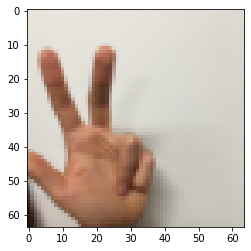

idx:113 oh label:[0. 0. 0. 0. 1. 0.] oh prediction:[0. 0. 0. 1. 0. 0.]


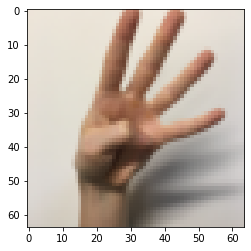

idx:115 oh label:[0. 0. 1. 0. 0. 0.] oh prediction:[0. 0. 0. 0. 1. 0.]


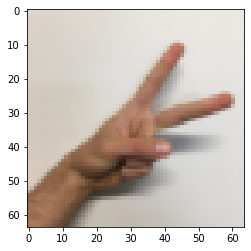

In [21]:
test_set_prediction = model.predict(test_set_x_orig)      # in logits form
test_set_prediction = tf.nn.softmax(test_set_prediction)  # in probabilities
print('test_set_prediction shape:' + str(test_set_prediction.shape))

idx=1 # for random checking

# finding the max
max_prediction = test_set_prediction.numpy().max(axis=1)
print('max_prediction shape:' + str(max_prediction.shape))

# convert the prediction to one hot encoding
one_hot_prediction = (test_set_prediction.numpy()[idx] == max_prediction[idx]).astype(float)

for idx in range(len(test_set_prediction.numpy())):
    # convert the prediction to one hot encoding
    one_hot_prediction = (test_set_prediction.numpy()[idx] == max_prediction[idx]).astype(float)

    if not np.array_equal(one_hot_prediction, one_hot_test_labels[idx]):
        # uncomment for debugging
        # print('idx:'+ str(idx) + ' max pred:' + str(max_prediction[idx]))
        # print('idx:'+ str(idx) + ' test_pre:' + str(test_set_prediction.numpy()[idx]))
        
        print('idx:'+ str(idx) + ' oh label:' + str(one_hot_test_labels[idx]) + ' oh prediction:' + str(one_hot_prediction))
        
        # show image
        plt.imshow(test_set_x_orig[idx])
        plt.show()